Data Shape: (10459, 24)
Missing Values per Column:
 RiskPerformance                       0
ExternalRiskEstimate                  0
MSinceOldestTradeOpen                 0
MSinceMostRecentTradeOpen             0
AverageMInFile                        0
NumSatisfactoryTrades                 0
NumTrades60Ever2DerogPubRec           0
NumTrades90Ever2DerogPubRec           0
PercentTradesNeverDelq                0
MSinceMostRecentDelq                  0
MaxDelq2PublicRecLast12M              0
MaxDelqEver                           0
NumTotalTrades                        0
NumTradesOpeninLast12M                0
PercentInstallTrades                  0
MSinceMostRecentInqexcl7days          0
NumInqLast6M                          0
NumInqLast6Mexcl7days                 0
NetFractionRevolvingBurden            0
NetFractionInstallBurden              0
NumRevolvingTradesWBalance            0
NumInstallTradesWBalance              0
NumBank2NatlTradesWHighUtilization    0
PercentTradesWBalance       

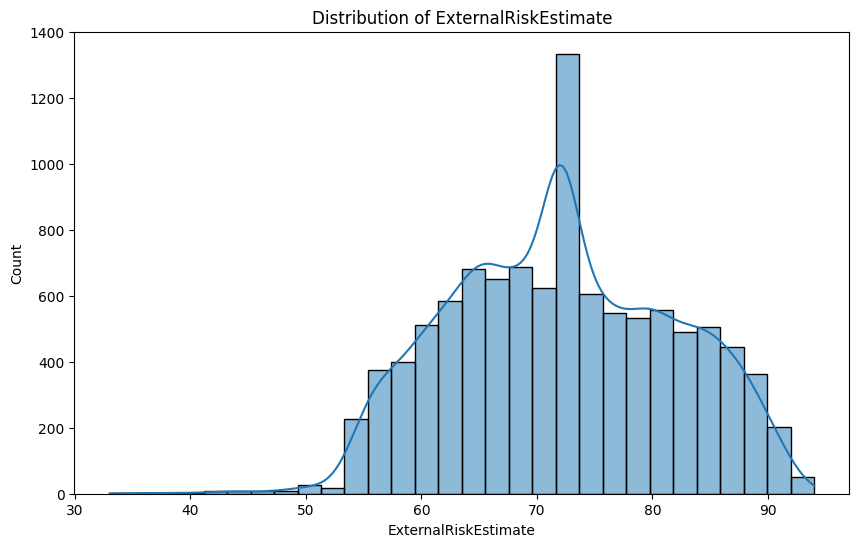

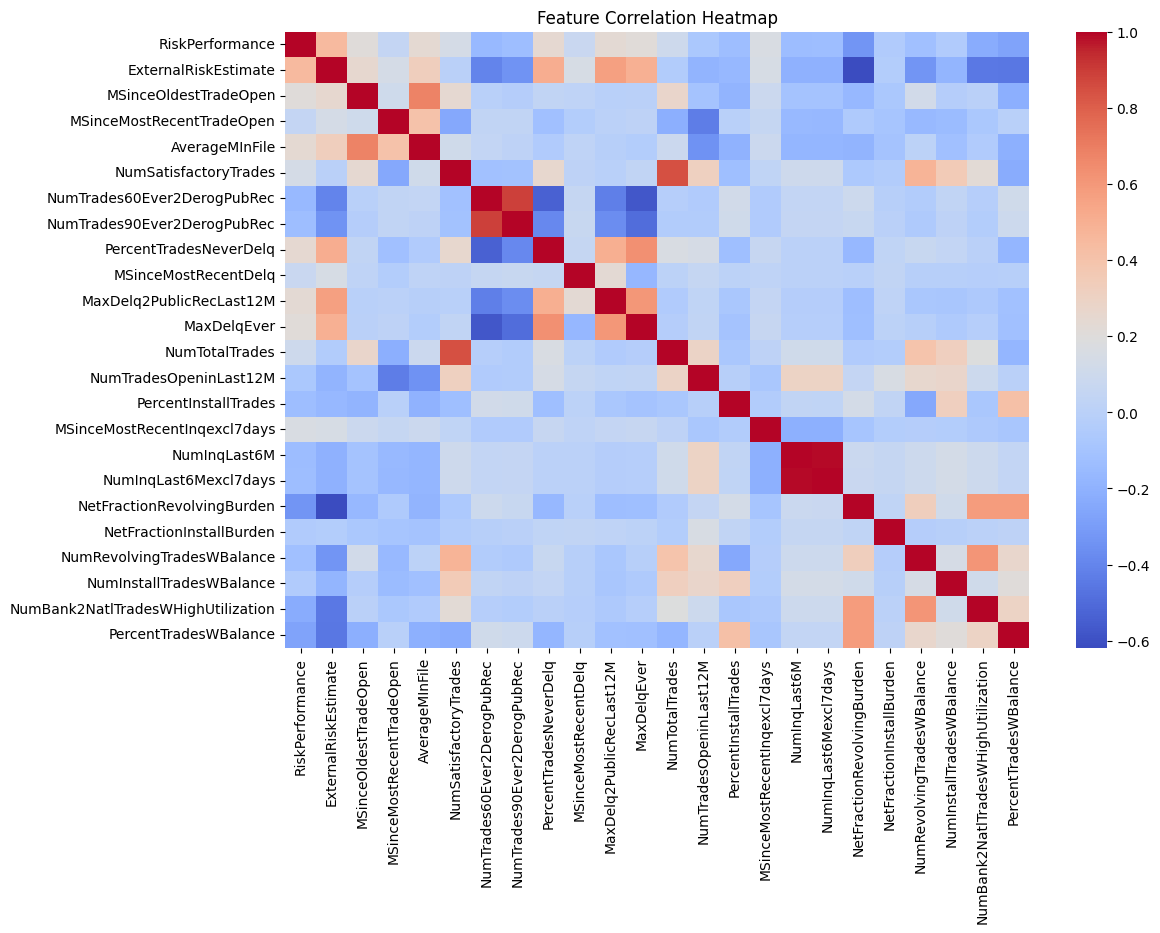

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import shap

# Load data
def load_and_clean_data(file_path='heloc_dataset_v1.csv'):
    df = pd.read_csv(file_path)
    
    # Convert target variable to binary (1 = Approved, 0 = Denied)
    df['RiskPerformance'] = df['RiskPerformance'].map({'Good': 1, 'Bad': 0})
    
    # Replace special values (-9, -8, -7) with NaN
    df.replace([-9, -8, -7], np.nan, inplace=True)
    
    # Impute missing values with median (robust to outliers)
    imputer = SimpleImputer(strategy='median')
    df.iloc[:, 1:] = imputer.fit_transform(df.iloc[:, 1:])
    
    return df

df = load_and_clean_data()

# Save cleaned data
df.to_csv("heloc_dataset_cleaned.csv", index=False)

# Exploratory Data Analysis (EDA)
def explore_data(df):
    print("Data Shape:", df.shape)
    print("Missing Values per Column:\n", df.isna().sum())
    print("Target Distribution:\n", df['RiskPerformance'].value_counts(normalize=True))
    
    # Distribution of a key financial feature
    plt.figure(figsize=(10, 6))
    sns.histplot(df['ExternalRiskEstimate'].dropna(), bins=30, kde=True)
    plt.title('Distribution of ExternalRiskEstimate')
    plt.savefig("distribution_external_risk_estimate.png")
    plt.show()
    
    # Correlation heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(df.corr(), cmap='coolwarm', annot=False)
    plt.title('Feature Correlation Heatmap')
    plt.savefig("feature_correlation_heatmap.png")
    plt.show()

explore_data(df)


In [13]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

# Load dataset
file_path = "heloc_dataset_cleaned.csv"
df = pd.read_csv(file_path)

# Separate features and target variable
X = df.drop(columns=['RiskPerformance'])
y = df['RiskPerformance']

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_pred)
    }

# Output results
results_df = pd.DataFrame(results).T
print("Model Evaluation Results:\n", results_df)

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Train best model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Evaluate best model
y_pred = best_rf.predict(X_test)
print("\nBest Random Forest Model Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


d:\Anaconda\envs\gba464\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model Evaluation Results:
                      Accuracy  Precision  Recall  F1 Score   AUC-ROC
Logistic Regression  0.718451   0.692596   0.739  0.715046  0.719317
Decision Tree        0.631931   0.614087   0.619  0.616534  0.631386
Random Forest        0.723231   0.731573   0.665  0.696700  0.720778
Gradient Boosting    0.725621   0.727564   0.681  0.703512  0.723742

Best Random Forest Model Evaluation:
Accuracy: 0.7251434034416826
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74      1092
           1       0.73      0.68      0.70      1000

    accuracy                           0.73      2092
   macro avg       0.73      0.72      0.72      2092
weighted avg       0.73      0.73      0.72      2092



In [14]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Training the best model
best_rf = grid_search.best_estimator_
best_rf.fit(X_train, y_train)

# Model Evaluation
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Save the best model
best_rf = grid_search.best_estimator_
joblib.dump(best_rf, "random_forest_heloc.pkl")
print("Model saved as 'random_forest_heloc.pkl'")


Best Model Accuracy: 0.7251434034416826
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.77      0.74      1092
           1       0.73      0.68      0.70      1000

    accuracy                           0.73      2092
   macro avg       0.73      0.72      0.72      2092
weighted avg       0.73      0.73      0.72      2092

Model saved as 'random_forest_heloc.pkl'


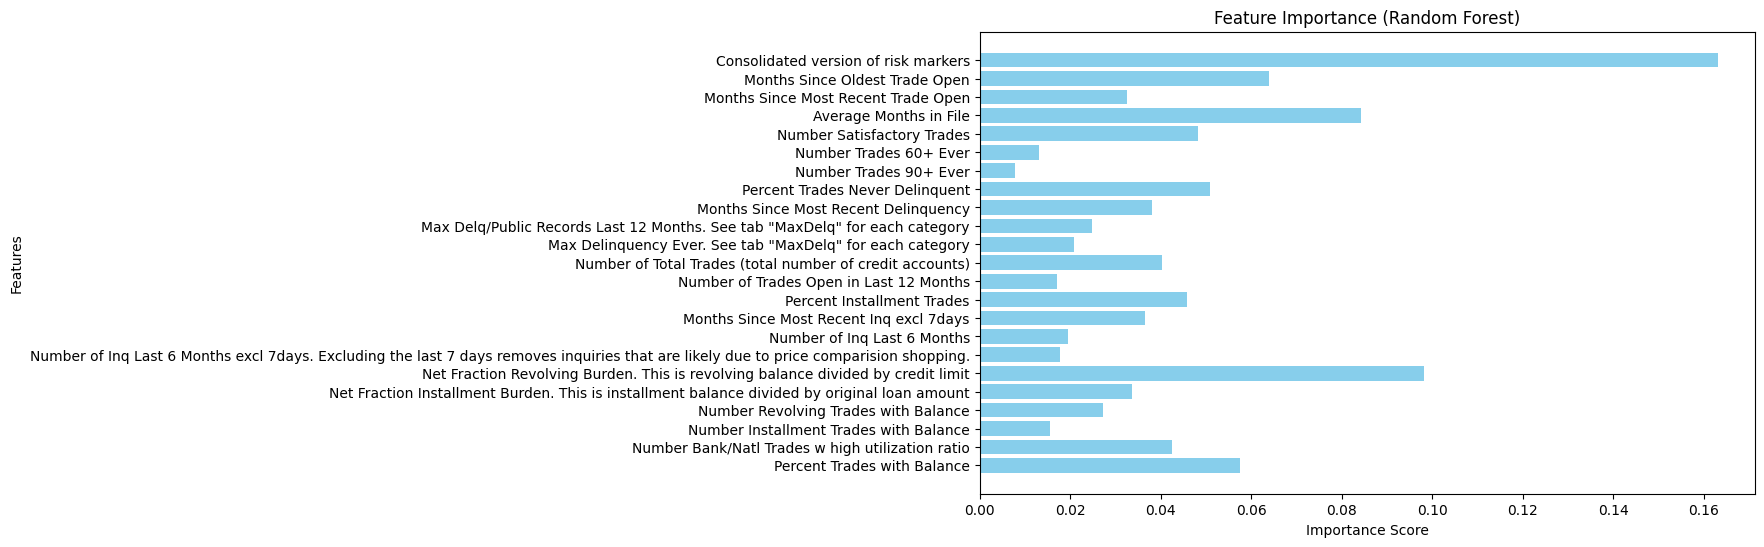

Feature importance plot saved as 'feature_importance_rf.png'


In [15]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import shap

# Load the best Random Forest model
best_rf = joblib.load("random_forest_heloc.pkl")

# Load cleaned dataset
file_path = "heloc_dataset_cleaned.csv"
df = pd.read_csv(file_path)
X = df.drop(columns=['RiskPerformance'])

# Load feature descriptions (user-friendly names)
dictionary_file_path = "heloc_data_dictionary-2.xlsx"
heloc_dict = pd.read_excel(dictionary_file_path, sheet_name="Data Dictionary")
feature_mapping = dict(zip(heloc_dict["Variable Names"], heloc_dict["Description"]))

# Rename dataset columns for better readability
X_renamed = X.rename(columns=feature_mapping)

# Extract feature importance
importances = best_rf.feature_importances_
feature_names = X_renamed.columns

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance (Random Forest)")
plt.gca().invert_yaxis()  # Highest importance on top
plt.savefig("feature_importance_rf.png")
plt.show()
print("Feature importance plot saved as 'feature_importance_rf.png'")


Adjusted SHAP values shape: (2092, 23)
X_test shape: (2092, 23)

Top 5 Features Influencing Loan Decision:
                               Feature  SHAP Value
7               PercentTradesNeverDelq    0.021223
22               PercentTradesWBalance    0.018257
21  NumBank2NatlTradesWHighUtilization    0.016503
13                PercentInstallTrades    0.015595
9             MaxDelq2PublicRecLast12M    0.011563


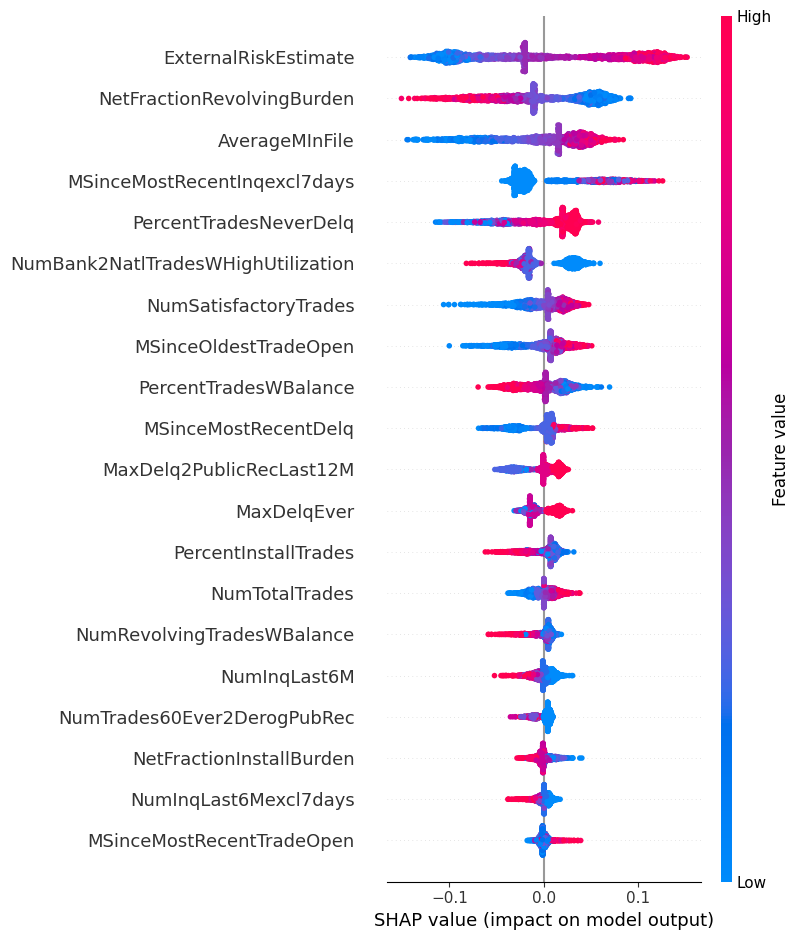

SHAP summary plot saved as 'shap_summary_plot.png'


<Figure size 640x480 with 0 Axes>

In [16]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Compute SHAP values for the test set (improving efficiency)
explainer = shap.TreeExplainer(best_rf)
shap_values = explainer.shap_values(X_test)

# Adjust SHAP values shape
shap_values = np.array(shap_values)
shap_values = shap_values[:, :, 1]  # Select class 1 (approved loan) SHAP contributions

# Print SHAP values shape to ensure it matches
print("Adjusted SHAP values shape:", shap_values.shape)
print("X_test shape:", X_test.shape)

# Select a test sample
sample_index = 0  
sample_data = X_test.iloc[sample_index:sample_index+1]  # Ensure shape (1, n_features)
shap_values_sample = shap_values[sample_index]  # Extract SHAP values for a single sample

# Ensure SHAP dimensions match
if len(shap_values_sample) == X_test.shape[1]:
    feature_importance = pd.DataFrame({
        "Feature": X_test.columns,
        "SHAP Value": shap_values_sample
    }).sort_values(by="SHAP Value", ascending=False)

    print("\nTop 5 Features Influencing Loan Decision:")
    print(feature_importance.head(5))
else:
    print(f"❌ Dimension mismatch! SHAP values length: {len(shap_values_sample)}, Feature count: {X_test.shape[1]}")

# Visualize SHAP Summary
plt.figure()
shap.summary_plot(shap_values, X_test)
plt.savefig("shap_summary_plot.png")
print("SHAP summary plot saved as 'shap_summary_plot.png'")
